In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

In [3]:
# DAG provided in appendix A
dag = {
    (1, 31), (2, 1), (3, 8), (4, 3), (5, 2), (6, 16), (7, 6), (8, 7), (9, 8), (10, 9), (11, 1), (12, 5), (13, 12), (14, 13), (15, 11), (16, 5), (17, 15), (17, 16), (18, 17), (19, 18), (20, 19), (21, 18), (22, 21), (23, 22), (24, 5), (25, 24), (26, 25), (27, 26), (28, 26), (29, 27), (29, 28), (30, 4), (30, 10), (30, 14), (30, 20), (30, 23), (30, 29)
}

# processing times provided in Appendix A
p = [3, 10, 2, 2, 5, 2, 14, 5, 6, 5, 5, 2, 3, 3, 5, 6, 6, 6, 2, 3, 2, 3, 14, 5, 18, 10, 2, 3, 6, 2, 10]

# due dates provided in Appendix A
d = [172, 82, 18, 61, 93, 71, 217, 295, 290, 287, 253, 307, 279, 73, 355, 34, 233, 77, 88, 122, 71, 181, 340, 141, 209, 217, 256, 144, 307, 329, 269]

num_nodes = len(p)

# initial solution for tabu search algorithm for given DAG
initial_solution = [30, 29, 23, 10, 9, 14, 13, 12, 4, 20, 22, 3, 27, 28, 8, 7, 19, 21, 26, 18, 25, 17, 15, 6, 24, 16, 5, 11, 2, 1, 31]

In [4]:
# finding all nodes that a given node can reach either directly or transitively
def get_all_reachable(dag):
    reachable = set()
    nodes = list(range(num_nodes))

    # marking all nodes reached from a direct edge as reachable
    for (u, v) in dag:
        reachable.add((u, v))

    # Floyd-Warshall algorithm
    for i in nodes:
        for j in nodes:
            for k in nodes:
                # transitive reachability, i.e. if i can reach j & j can reach k, i can reach k 
                if (i, j) in reachable and (j, k) in reachable:
                    reachable.add((i, k))

    return reachable

reachable = get_all_reachable(dag)

In [5]:
def generate_initial_solution(dag):
    # generating an initial solution using a topical sort
    num_edges_into_node = {}
    all_nodes = set(np.array(list(range(num_nodes))) + 1)
    
    # initializing dictionary
    for node in all_nodes:
        num_edges_into_node[node] = 0
    
    for (u, v) in dag:
        num_edges_into_node[v] += 1
        
    # finding all nodes with no edges into it
    processing_queue = deque([node for node in all_nodes if num_edges_into_node[node] == 0])
    initial_solution = []
    while processing_queue:
        node = processing_queue.popleft()
        initial_solution.append(node)
        
        for (u, v) in dag:
            if u == node:
                num_edges_into_node[v] -= 1
                if num_edges_into_node[v] == 0:
                    processing_queue.append(v)
    
    does_contain_cycles = len(initial_solution) != len(all_nodes)
    if not does_contain_cycles:
        return initial_solution
    else:
        return [] # if there is a cycle, no way to do tabu search

In [178]:
# checking if we can swap two nodes at positions i, j in a schedule where i < j
def is_valid_swap(job_i, job_j, reachable=reachable):
    return (job_i, job_j) not in reachable and (job_j, job_i) not in reachable # if either u depends on v or v depends on u, cannot swap nodes

def generate_neighboring_schedule(schedule, swap_index, reachable=reachable):
    for step_counter in range(len(schedule)):
        i = (swap_index + step_counter) % (len(schedule) - 1)
        j = (swap_index + step_counter + 1) % (len(schedule) - 1)
        job_i, job_j = schedule[i], schedule[j]
        if is_valid_swap(job_i, job_j, reachable):
            neighboring_schedule = schedule[:]
            neighboring_schedule[i], neighboring_schedule[j] = neighboring_schedule[j], neighboring_schedule[i]
            return neighboring_schedule, (job_i, job_j), i
                
    # if no valid neighbors, we are done            
    return [], (-1, -1), -1

def evaluate_tardiness(schedule, p, d):
    total_tardiness = 0
    current_time = 0
    
    for job in schedule:
        completion_time = current_time + p[job-1] # -1 because 0 indexing
        tardiness = max(0, completion_time - d[job-1])
        total_tardiness += tardiness
        current_time = completion_time
    
    return total_tardiness

def tabu_search(dag, p, d, num_iterations=100, tolerance=10, tabu_list_length=20, use_default_initial_solution=True, verbose=False):
    # initializing parameters
    tabu_list = deque(maxlen=tabu_list_length)
    reachable = get_all_reachable(dag)
    current_schedule = initial_solution if use_default_initial_solution else generate_initial_solution(dag)
    current_tardiness = evaluate_tardiness(current_schedule, p, d)
    best_schedule = current_schedule.copy()
    best_tardiness = current_tardiness
    new_swap_index = 0
    swapped_i_for_iteration = set() # keeps track of all swap positions we have seen for a given iteration, if we see a repeat then end search
    iteration = 0
    nums_per_iter = 0

    if verbose:
        # iteration 0, aka just the initial solution
        print("*******************************************************")
        print(f"Iteration: {iteration}")
        print(f"Current Schedule: {current_schedule}")
        print(f"Current Tardiness: {current_tardiness}")
        print(f"Best Schedule: {best_schedule}")
        print(f"Best Tardiness: {best_tardiness}")

    iteration += 1
    while iteration <= num_iterations:
        
        neighbor_schedule, (job_i, job_j), recently_swapped_index = generate_neighboring_schedule(current_schedule, new_swap_index, reachable)
        nums_per_iter += 1   
        if not neighbor_schedule or recently_swapped_index in swapped_i_for_iteration: # if no valid neighbors or we have looked at all valid swaps with no candidates, we are done
            return best_schedule, best_tardiness
        swapped_i_for_iteration.add(recently_swapped_index)
        new_swap_index = recently_swapped_index + 1 # moving right one to not just swap job back
        neighbor_tardiness = evaluate_tardiness(neighbor_schedule, p, d)
        delta = current_tardiness - neighbor_tardiness
        is_tabu = (job_i, job_j) in tabu_list or (job_j, job_i) in tabu_list
        is_better = neighbor_tardiness < best_tardiness
        is_in_threshold = delta > -1 * tolerance

        if verbose:
            print("*******************************************************")
            print(f"Iteration: {iteration}")
            print(f"Neighbors Checked: {nums_per_iter}")
            print(f"Current Schedule: {current_schedule}")
            print(f"Current Tardiness: {current_tardiness}")
            print(f"Best Schedule: {best_schedule}")
            print(f"Best Tardiness: {best_tardiness}")
            print(f"Candidate Schedule: {neighbor_schedule}")
            print(f"Candidate Tardiness: {evaluate_tardiness(neighbor_schedule, p, d)}")
            print(f"Jobs Swapped: {job_i, job_j}")
            print(f"Tabu List: {tabu_list}")
            print(f"Is Tabu: {is_tabu}")
            
            if is_better and not is_tabu:
                print(f"New Solution Found!")
            elif is_in_threshold and not is_tabu and not is_better:
                print(f"New Intermediate Schedule Found: ({current_tardiness} - {neighbor_tardiness}) > -10")
            elif not is_in_threshold and not is_tabu:
                print(f"Valid Neighbor, Not Within Threshold: ({current_tardiness} - {neighbor_tardiness}) < -10")
            
        if not is_tabu and is_in_threshold or is_better:
            current_schedule, current_tardiness = neighbor_schedule, neighbor_tardiness
            tabu_list.append((job_i, job_j))
            iteration += 1
            nums_per_iter = 0
            swapped_i_for_iteration = set()
            if is_better:
                best_tardiness = current_tardiness
                best_schedule = current_schedule
    if verbose:
        print(f"End of search.")
        print(f"Best Schedule: {best_schedule}")
        print(f"Best Tardiness: {best_tardiness}")
    return best_schedule, best_tardiness

In [174]:
initial_tardiness = evaluate_tardiness(initial_solution, p, d)
print(initial_tardiness)

341


In [176]:
best_schedule, best_tardiness = tabu_search(dag, p, d, num_iterations=1000, verbose=True, tolerance=10)

*******************************************************
Iteration: 0
Current Schedule: [30, 29, 23, 10, 9, 14, 13, 12, 4, 20, 22, 3, 27, 28, 8, 7, 19, 21, 26, 18, 25, 17, 15, 6, 24, 16, 5, 11, 2, 1, 31]
Current Tardiness: 341
Best Schedule: [30, 29, 23, 10, 9, 14, 13, 12, 4, 20, 22, 3, 27, 28, 8, 7, 19, 21, 26, 18, 25, 17, 15, 6, 24, 16, 5, 11, 2, 1, 31]
Best Tardiness: 341
*******************************************************
Iteration: 1
Neighbors Checked: 1
Current Schedule: [30, 29, 23, 10, 9, 14, 13, 12, 4, 20, 22, 3, 27, 28, 8, 7, 19, 21, 26, 18, 25, 17, 15, 6, 24, 16, 5, 11, 2, 1, 31]
Current Tardiness: 341
Best Schedule: [30, 29, 23, 10, 9, 14, 13, 12, 4, 20, 22, 3, 27, 28, 8, 7, 19, 21, 26, 18, 25, 17, 15, 6, 24, 16, 5, 11, 2, 1, 31]
Best Tardiness: 341
Candidate Schedule: [30, 23, 29, 10, 9, 14, 13, 12, 4, 20, 22, 3, 27, 28, 8, 7, 19, 21, 26, 18, 25, 17, 15, 6, 24, 16, 5, 11, 2, 1, 31]
Candidate Tardiness: 341
Jobs Swapped: (29, 23)
Tabu List: deque([], maxlen=20)
Is Tabu: 

In [157]:
tolerances = [i for i in range(0, 30, 2)]
tabu_list_lengths = [i for i in range(0, 70, 5)]
num_iters = [100, 500, 1000, 2000, 5000, 10000]

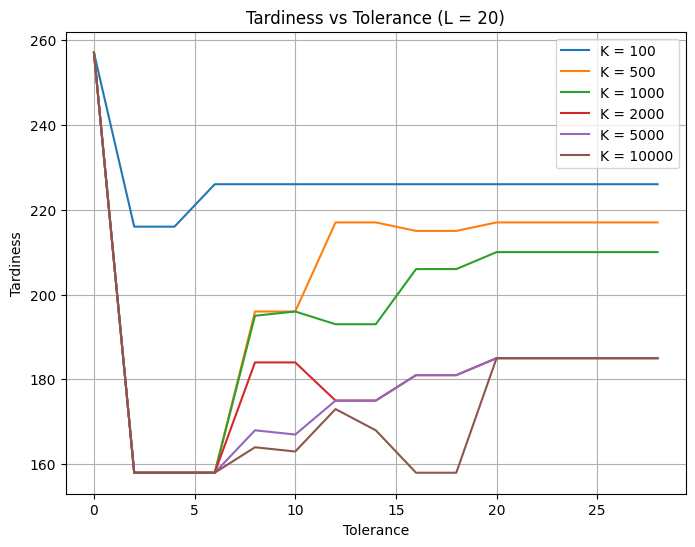

In [151]:
tardiness_at_tolerance = []
for iter in num_iters:
    tardy_at_iter = []
    for tolerance in tolerances:
        _, best_tardiness = tabu_search(dag, p, d, tolerance=tolerance, num_iterations=iter)
        tardy_at_iter.append(best_tardiness)
    tardiness_at_tolerance.append(tardy_at_iter)
    
plt.figure(figsize=(8, 6))
for i, iter in enumerate(num_iters):
    plt.plot(tolerances, tardiness_at_tolerance[i], label=f"K = {iter}")

# Add labels and title
plt.xlabel('Tolerance')
plt.ylabel('Tardiness')
plt.title('Tardiness vs Tolerance (L = 20)')

plt.grid(True)
plt.legend()
plt.show()

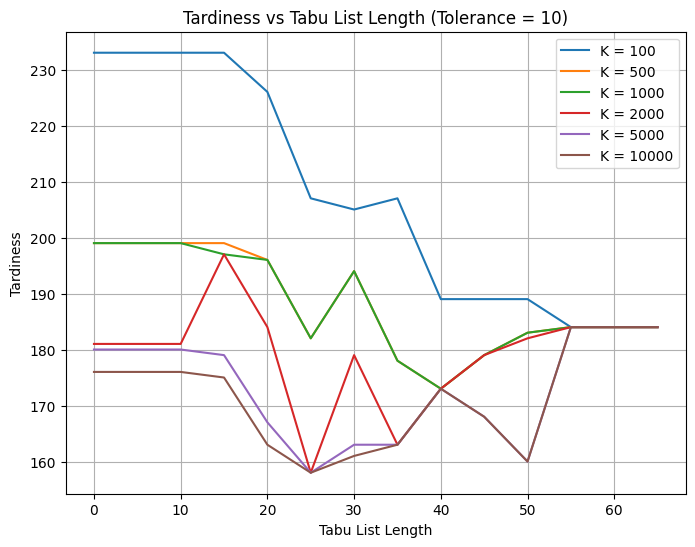

In [158]:
tardiness_at_L = []
for iter in num_iters:
    tardy_at_iter = []
    for L in tabu_list_lengths:
        _, best_tardiness = tabu_search(dag, p, d, tabu_list_length=L, num_iterations=iter)
        tardy_at_iter.append(best_tardiness)
    tardiness_at_L.append(tardy_at_iter)

plt.figure(figsize=(8, 6))
for i, iter in enumerate(num_iters):
    plt.plot(tabu_list_lengths, tardiness_at_L[i], label=f"K = {iter}")

# Add labels and title
plt.xlabel('Tabu List Length')
plt.ylabel('Tardiness')
plt.title('Tardiness vs Tabu List Length (Tolerance = 10)')

plt.grid(True)
plt.legend()
plt.show()

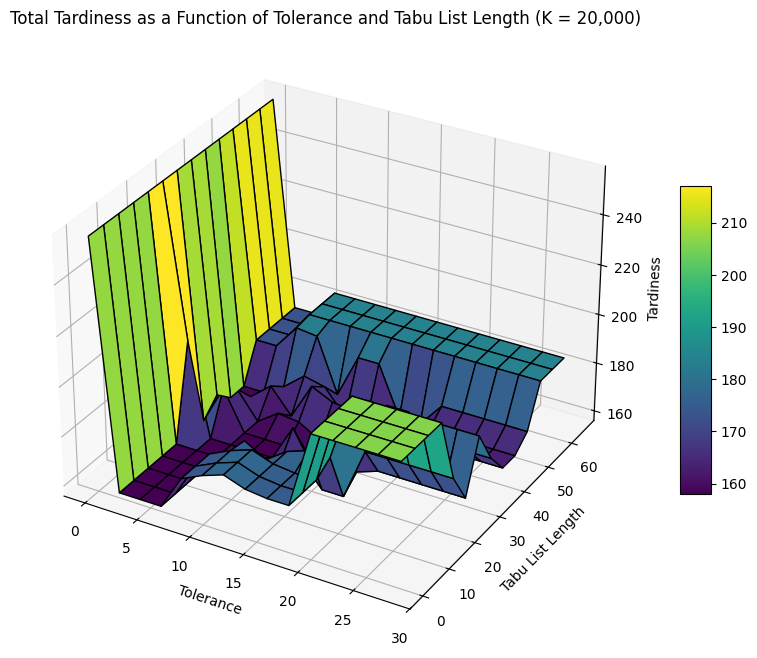

In [185]:
tardinesses = []
for L in tabu_list_lengths:
    for tolerance in tolerances:
        schedule, tardiness = tabu_search(dag, p, d, tolerance=tolerance, tabu_list_length=L, num_iterations=20000)
        tardinesses.append((tardiness, tolerance, L))

tolerances = sorted(set(x[1] for x in tardinesses))
tabu_list_lengths = sorted(set(x[2] for x in tardinesses))

# Create a 2D grid
tol, tabu = np.meshgrid(tolerances, tabu_list_lengths)
tardiness_grid = np.zeros_like(tol, dtype=float)
for tardiness, tolerance, L in tardinesses:
    i = tabu_list_lengths.index(L)
    j = tolerances.index(tolerance)
    tardiness_grid[i, j] = tardiness

# 3D Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(tol, tabu, tardiness_grid, cmap='viridis', edgecolor='k')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

ax.set_xlabel('Tolerance')
ax.set_ylabel('Tabu List Length')
ax.set_zlabel('Tardiness')
ax.set_title('Total Tardiness as a Function of Tolerance and Tabu List Length (K = 20,000)')

plt.show()

In [181]:
# brute force finding the optimal solution
tardinesses = []
best_s = []
best_t = 1000
best_l = None
best_tol = None
for L in tabu_list_lengths:
    for tolerance in tolerances:
        schedule, tardiness = tabu_search(dag, p, d, tolerance=tolerance, tabu_list_length=L, num_iterations=20000)
        tardinesses.append((schedule, tardiness, tolerance, L))
        if tardiness < best_t:
            best_t, best_s, best_l, best_tol = tardiness, schedule, L, tolerance
print(best_t)
print(best_s)
print(best_l)
print(best_tol)


158
[30, 4, 20, 3, 10, 9, 8, 7, 6, 23, 22, 21, 14, 19, 18, 17, 16, 29, 28, 13, 27, 26, 25, 24, 12, 5, 2, 15, 11, 1, 31]
0
2
